In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import lddmm
import vis
import nibabel as nib
import tensorflow as tf

importing vis


# Input the location of the waxholm atlas

In [2]:
atlas_filename = '/cis/home/dtward/Documents/waxholm_rat_atlas/WHS_SD_rat_atlas_v2_pack/WHS_SD_rat_T2star_v1.01.nii.gz'
label_filename = '/cis/home/dtward/Documents/waxholm_rat_atlas/WHS_SD_rat_atlas_v2_pack/WHS_SD_rat_atlas_v2.nii.gz'

In [3]:
# load the image
img_atlas = nib.load(atlas_filename)
nxI = img_atlas.header['dim'][1:4]
dxI = img_atlas.header['pixdim'][1:4]
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]
I0 = img_atlas.get_data().squeeze()

In [4]:
# load labels for a brain mask
img_label = nib.load(label_filename)
L = img_label.get_data().squeeze()
I = I0 * (L > 0)
I = I - np.mean(I)
I = I / np.std(I)

<IPython.core.display.Javascript object>


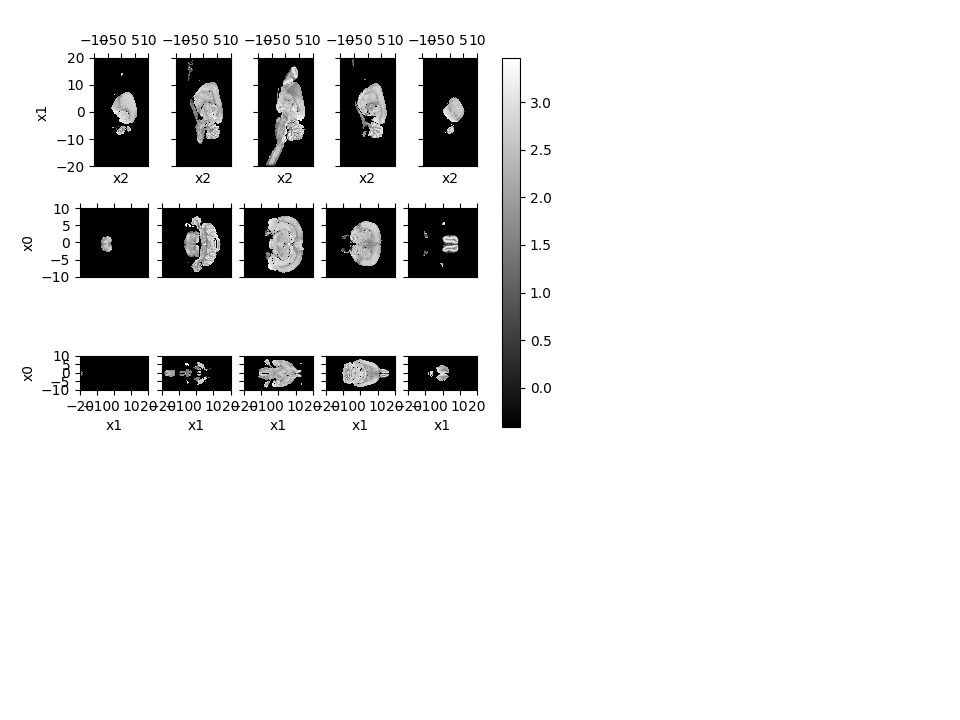

In [5]:
# display the atlas
f = plt.figure()
vis.imshow_slices(I,x=xI,fig=f,colorbar=True)
f.canvas.draw()

In [6]:
# downsample
I = lddmm.down2(I.astype(float))
dxI = dxI*2.0
nxI = I.shape
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]

In [7]:
# crop?


<IPython.core.display.Javascript object>


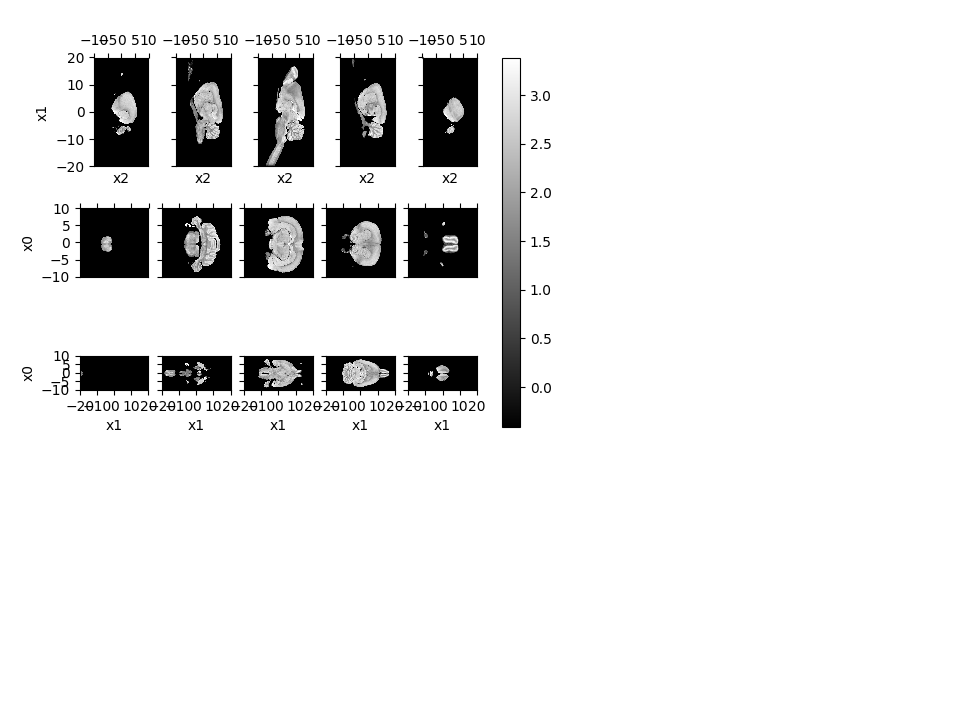

In [8]:
# display the atlas
f = plt.figure()
vis.imshow_slices(I,x=xI,fig=f,colorbar=True)
f.canvas.draw()

# Input orientation
Look at the above figure and input orientation as a three character string (see above).

Characters must be L/R (left or right), A/P (anterior or posterior), S/I (superior or inferior)

The first character says the orientation of the positive x0 axis.

The second character says the orientation of the positive x1 axis.

The third character says the orientation of the positive x2 axis.

If there is ambiguity between left and right, we suggest using a right handed coordinate system.

Note that 'LAS' is a canonical coordinate system in MRI, even though tit is not right handed.

In [9]:
atlas_orientation = 'LAS'

# Input the location of your stack of tifs

In [10]:
directory = 'something'

In [11]:
# load the the tifs

In [12]:
# downsample to atlas res

In [13]:
# display them

In [14]:
# here load from filename
target_filename = '/cis/home/dtward/Documents/\
audry_rat_mouse/work_AB_Rat_NewbornNeuron/\
YoungRat161135SagittalMidlineUp/inhomogeneity_corrected/\
down_15_15_31_corrected.img'
target_filename = '/cis/home/dtward/Documents/\
audry_rat_mouse/work_AB_Rat_NewbornNeuron/\
YoungRat161135SagittalMidlineUp/downsample/\
down_15_15_31.img'
    

In [15]:
img_target = nib.load(target_filename)
nxJ = img_target.header['dim'][1:4]
dxJ = img_target.header['pixdim'][1:4]
# change to mm
dxJ /= 1000.0
xJ = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJ,dxJ)]
J = img_target.get_data().squeeze()

<IPython.core.display.Javascript object>


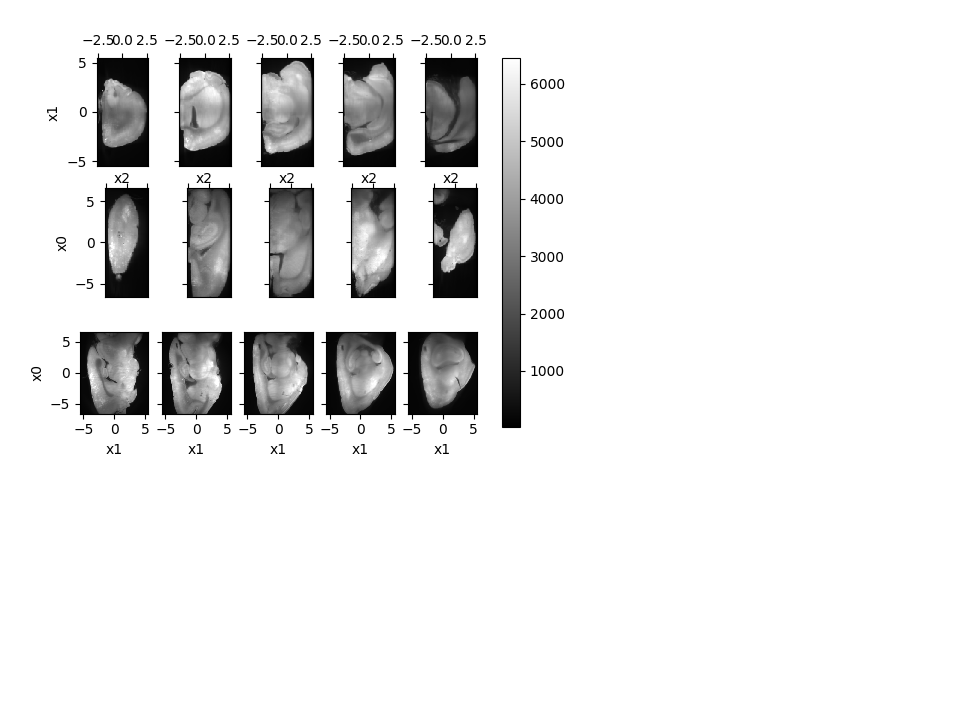

In [16]:
# display the target
f = plt.figure()
vis.imshow_slices(J,x=xJ,fig=f,colorbar=True)
f.canvas.draw()

# Input orientation
Look at the above figure and input orientation as a three character string (see above).

If there is ambiguity, we suggest using a right handed coordinate system (or the same system as above).


In [17]:
target_orientation = 'PIL'

# Verify the 3D orientation matches the atlas

<IPython.core.display.Javascript object>


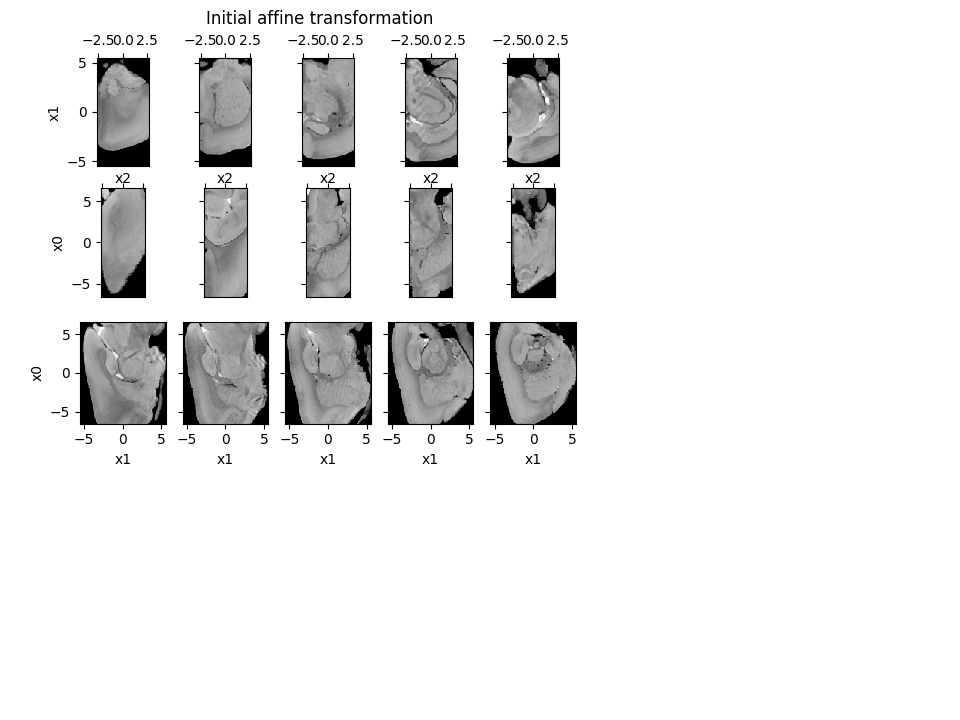

In [18]:
# input orientation
A = lddmm.orientation_to_matrix(atlas_orientation, target_orientation)

# now we want to shift in direction of -x2
A = np.array([[1,0,0,0],
             [0,1,0,0],
             [0,0,1,-2],
             [0,0,0,1]])@A

# now we want to shift in direction of +x2
A = np.array([[1,0,0,0],
             [0,1,0,2],
             [0,0,1,0],
             [0,0,0,1]])@A

# now we want to shift in direction of -x0 (move cerebellum out of picture)
A = np.array([[1,0,0,3],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1]])@A


Id = lddmm.affine_transform_data(*xI,I,A,*xJ)
f = plt.figure()
vis.imshow_slices(Id,x=xJ,fig=f)
f.suptitle('Initial affine transformation')
f.canvas.draw()


## Inhomogeneity correction 
This is essential, either part of matching code or as a preprocessing step.

<IPython.core.display.Javascript object>


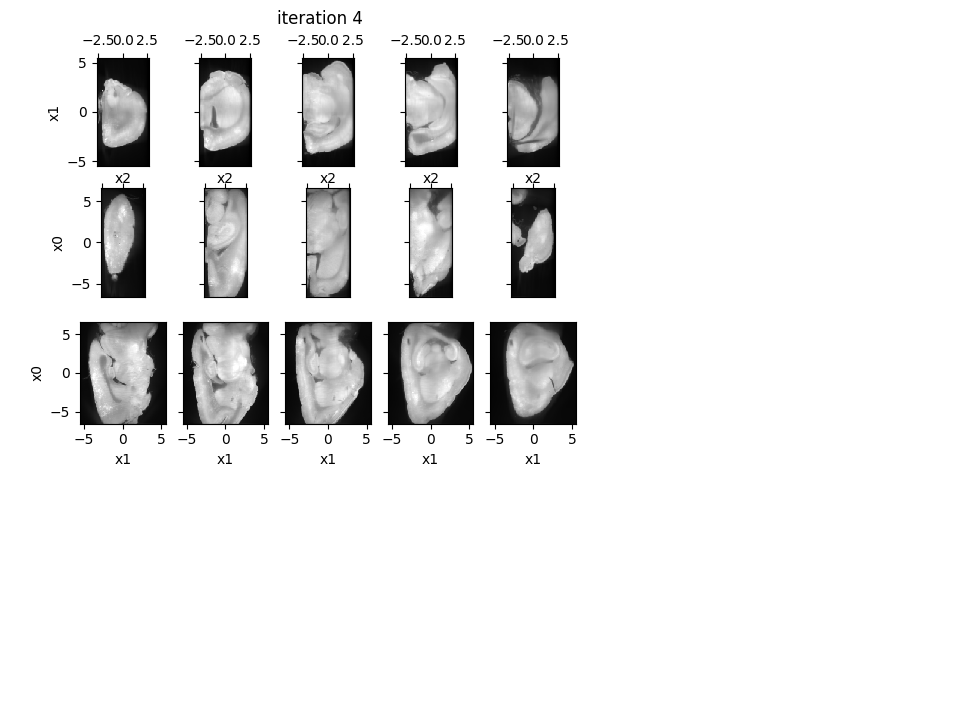

<IPython.core.display.Javascript object>


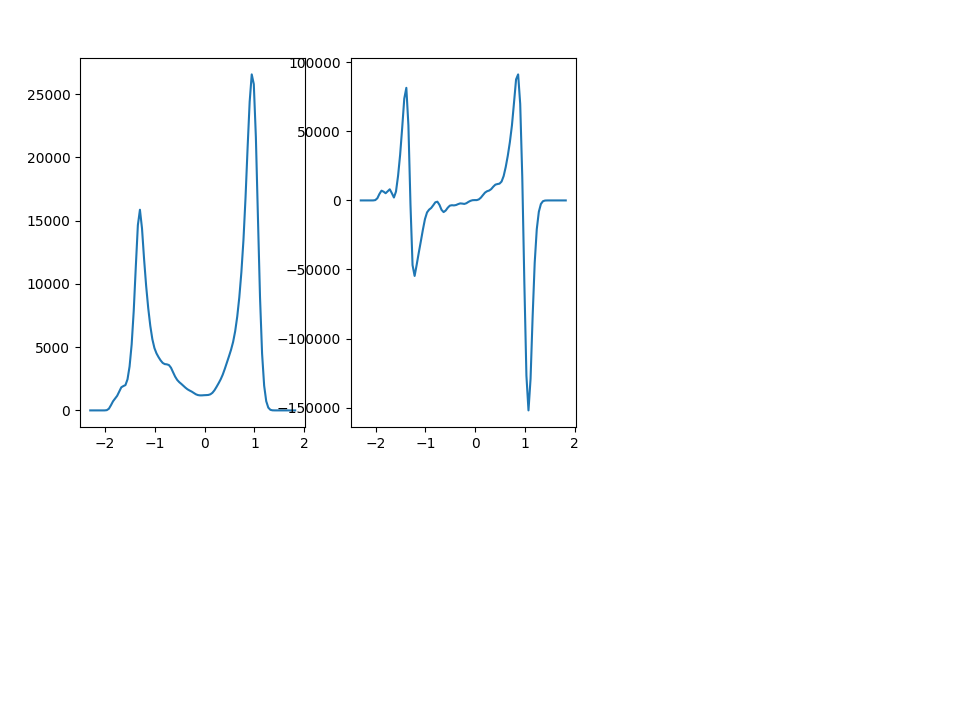

/cis/home/dtward/testenv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [ ]:
# make smoothing kernel
fJ = [np.arange(n)/n/d for n,d in zip(nxJ,dxJ)]
a = 1.0
p = 2.0
FJ = np.meshgrid(*fJ,indexing='ij')
Lhat = (1.0 - 2.0*a**2*(\
                     (np.cos(2.0*np.pi*FJ[0]*dxJ[0]) - 1.0)/dxJ[0]**2 \
                     + (np.cos(2.0*np.pi*FJ[1]*dxJ[1]) - 1.0)/dxJ[1]**2 \
                     + (np.cos(2.0*np.pi*FJ[2]*dxJ[2]) - 1.0)/dxJ[2]**2 \
                    ))**p
Khat = 1.0/(Lhat**2)

# anyway, compute histogram
import scipy.interpolate as spi
f = plt.figure()
f2,ax2 = plt.subplots(1,2)
nb = 100
minlog = 100
niter = 5
e = 2e-1
    
Jc = np.array(J)
Jc[Jc < minlog] = minlog
lJc = np.log(Jc)
# normalize
lJc = (lJc - np.mean(lJc))/np.std(lJc)
for it in range(niter):
    binrange = np.array([np.min(lJc),np.max(lJc)])
    binrange = np.mean(binrange) + np.diff(binrange)*np.array([-1,1])/2.0*1.25
    bins = np.linspace(binrange[0],binrange[1],nb)
    hist =  np.zeros_like(bins)
    db = bins[2] - bins[1]
    width = db*1.0
    for i in range(nb):
        hist[i] = np.sum( np.exp( - (lJc.ravel() - bins[i])**2 /2.0/width**2) * np.sqrt(2.0*np.pi*width**2) )
    dhist = np.gradient(hist,db)
    ax2[0].cla()
    ax2[0].plot(bins,hist)
    ax2[1].cla()
    ax2[1].plot(bins,dhist)
    
    # now we sample the image  
    lJch = spi.interp1d(bins,dhist)(lJc)
    lJchs = np.sign(lJch)
    
    # blur it
    lJchsb = np.fft.ifftn(np.fft.fftn(lJchs) * Khat).real
    vis.imshow_slices(lJchsb,fig=f,x=xJ)
    
    # step

    lJc = lJc + e * lJchsb
    
    # normalize
    lJc = (lJc - np.mean(lJc))/np.std(lJc)
    Jc = np.exp(lJc)
    f.clf()
    vis.imshow_slices(Jc,fig=f,x=xJ)
    f.suptitle('iteration {}'.format(it))
    
    # update figures and end loop
    f.canvas.draw()
    f2.canvas.draw()


In [ ]:
# again with padding

# Run the registration

In [ ]:
# downsample data
ndown = 2
dxId = np.array(dxI)
dxJd = np.array(dxJ)
Id = np.array(I)
Jd = np.array(Jc)
for d in range(ndown):
    # downsample
    Id = lddmm.down2(Id.astype(float))
    dxId = dxId*2.0
    
    Jd = lddmm.down2(Jd.astype(float))
    dxJd = dxJd*2.0

nxId = Id.shape
xId = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxId,dxId)]
nxJd = Jd.shape
xJd = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJd,dxJd)]

Set default parameters
Initial affine transform [[ 0. -1.  0.  3.]
 [ 0.  0. -1.  2.]
 [ 1.  0.  0. -2.]
 [ 0.  0.  0.  1.]]
Got parameters


<IPython.core.display.Javascript object>


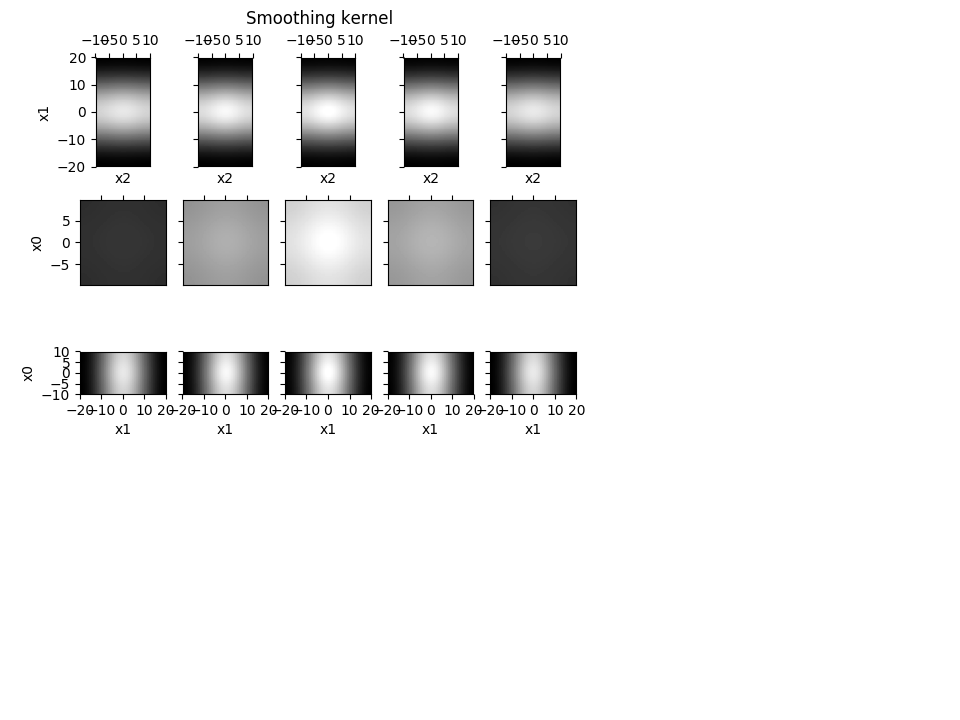

Built energy operators
Built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


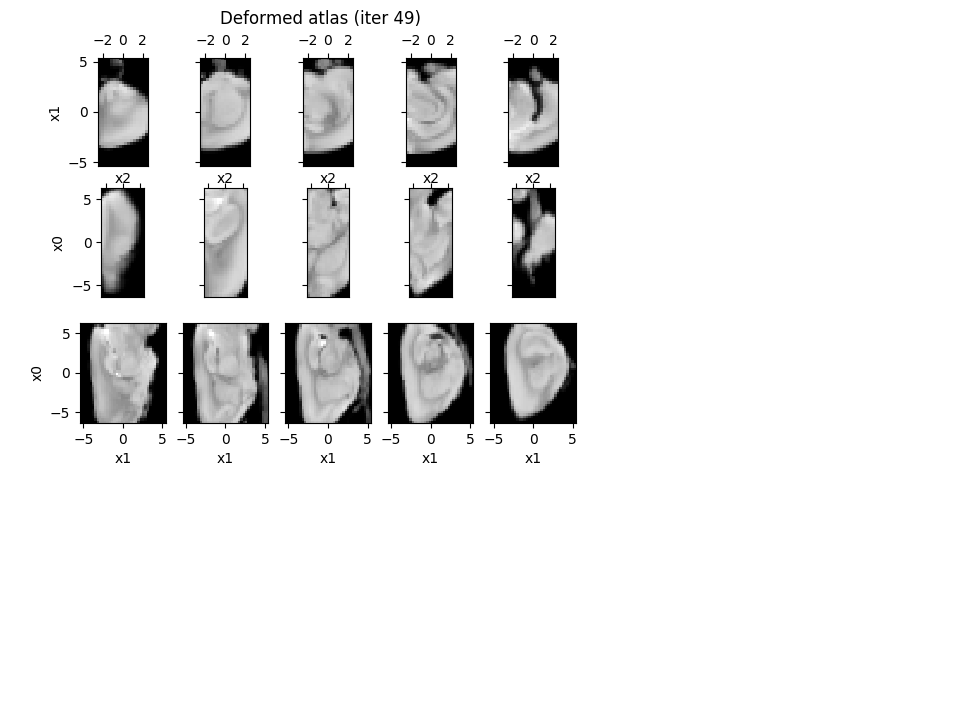

<IPython.core.display.Javascript object>


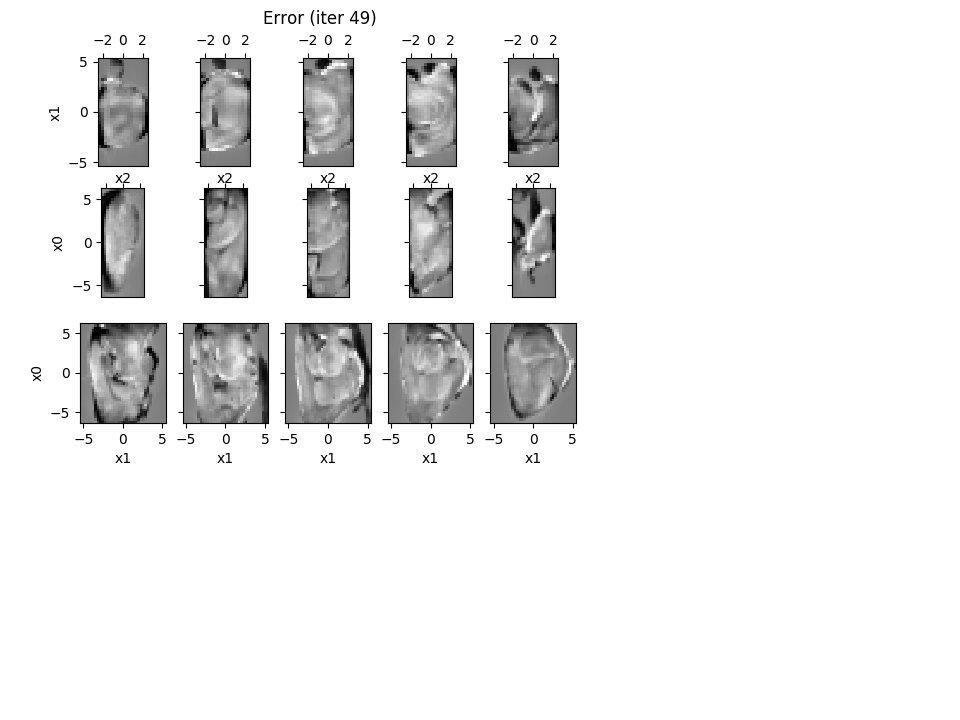

<IPython.core.display.Javascript object>


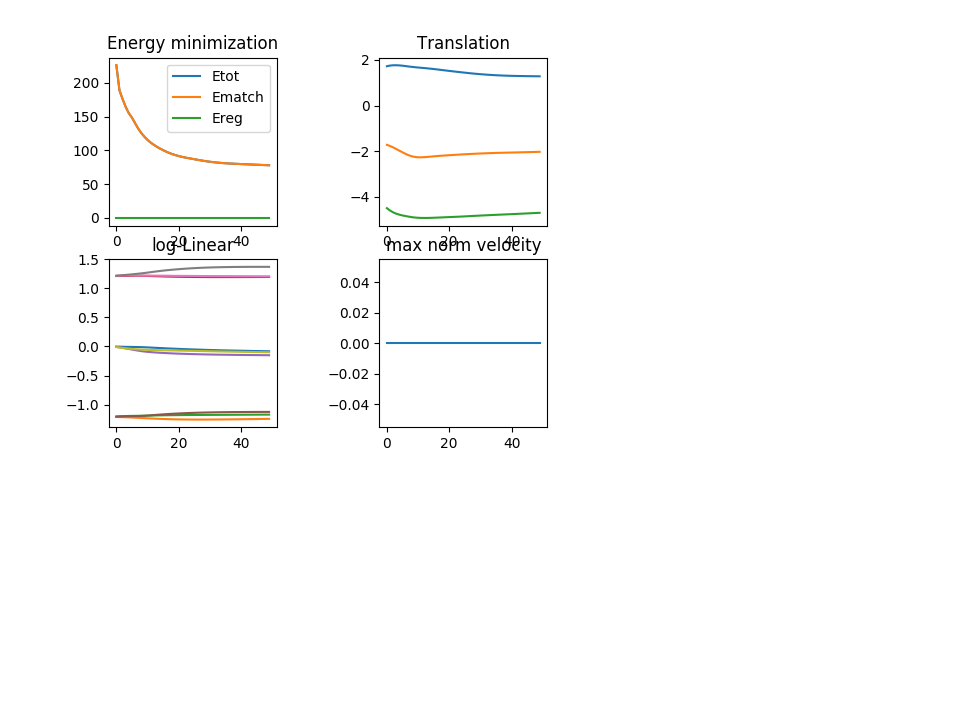

<IPython.core.display.Javascript object>


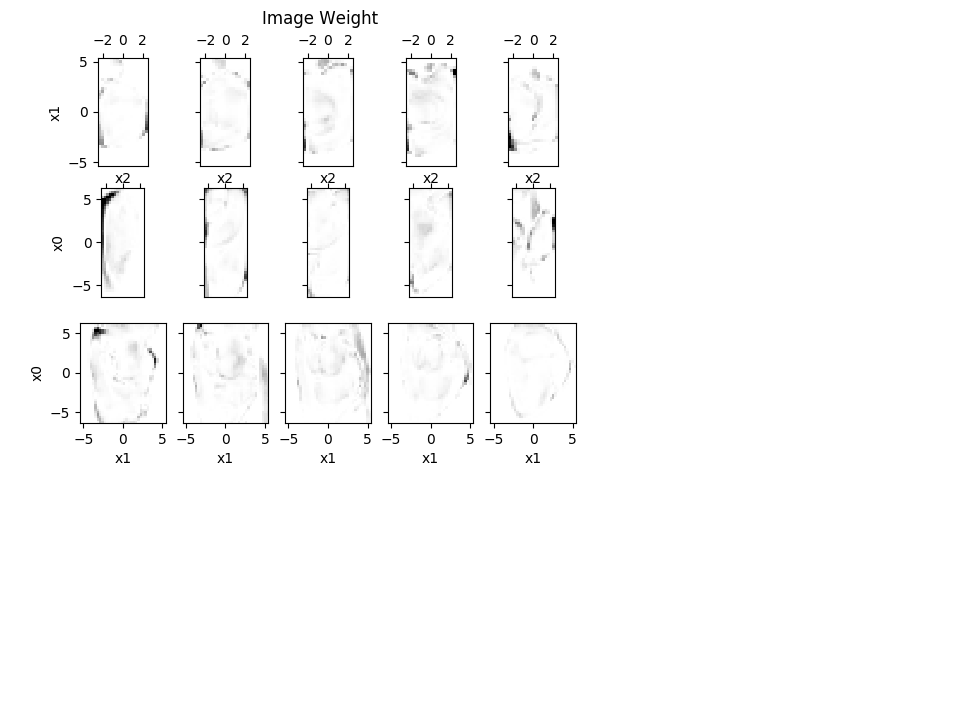

<IPython.core.display.Javascript object>


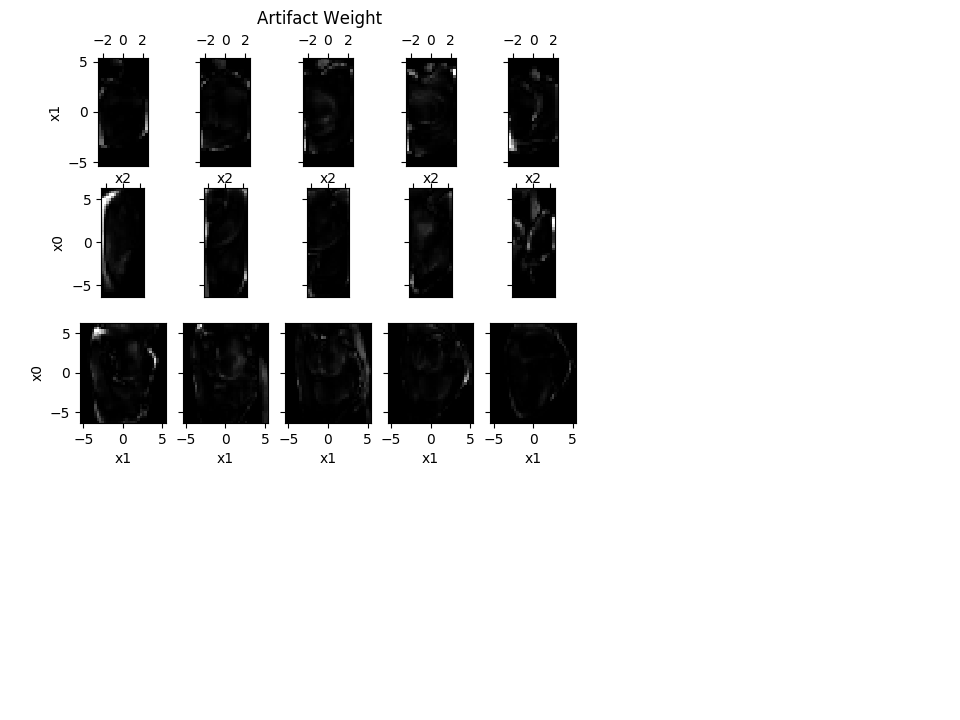

Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 1.6396035757038533e-07


/cis/home/dtward/testenv/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Finished iteration 0, energy 2.258962e+02 (match 2.258962e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 1.080678717124875e-07
Finished iteration 1, energy 1.886684e+02 (match 1.886684e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 1.6697607161599983e-07
Finished iteration 2, energy 1.758315e+02 (match 1.758315e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 2.401090506497559e-07
Finished iteration 3, energy 1.641867e+02 (match 1.641867e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 3.103112457621335e-07
Finished iteration 4, energy 1.549158e+02 (match 1.549158e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 2.649007052072998e-07
Finished iteration 5, energy 1.484

Updating weights
logm result may be inaccurate, approximate err = 2.615314409342235e-07
Finished iteration 43, energy 7.911853e+01 (match 7.911853e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 4.1402754296558356e-07
Finished iteration 44, energy 7.891904e+01 (match 7.891904e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 7.941710060345716e-07
Finished iteration 45, energy 7.872190e+01 (match 7.872190e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 3.0959060618783684e-07
Finished iteration 46, energy 7.852891e+01 (match 7.852891e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 4.7173012340612877e-07
Finished iteration 47, energy 7.833636e+01 (match 7.833636e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm resul

In [ ]:
# start at low res, affine only
naffine = 50
niter = 50
eL = 0.0
eT = 1e-3 # decent value
eL = 1e-5

#EM algorithm
nMstep = 1
nMstep_affine = 1

# matching cost
sigmaM = 1.0

down = 2**ndown
outd2 = lddmm.lddmm(Id,Jd,
                    xI=xId,xJ=xJd,
                    A0=A,
                    niter = niter,
                    naffine=naffine,
                    eT=eT*down, eL=eL*down,
                    nMstep=nMstep, nMstep_affine=nMstep_affine,
                    sigmaM=sigmaM
                   )

In [ ]:
# go to higher resolution
# downsample data
ndown = 1
dxId = np.array(dxI)
dxJd = np.array(dxJ)
Id = np.array(I)
Jd = np.array(Jc)
for d in range(ndown):
    # downsample
    Id = lddmm.down2(Id.astype(float))
    dxId = dxId*2.0
    
    Jd = lddmm.down2(Jd.astype(float))
    dxJd = dxJd*2.0

nxId = Id.shape
xId = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxId,dxId)]
nxJd = Jd.shape
xJd = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJd,dxJd)]

In [ ]:
dxJ,dxJd

(array([0.07725, 0.07725, 0.0775 ], dtype=float32),
 array([0.1545, 0.1545, 0.155 ], dtype=float32))

Set default parameters
Initial affine transform [[ 1.0316484e-03 -9.2876130e-01 -1.1448792e-02  2.9170871e+00]
 [ 1.4599124e-02 -6.1713435e-02 -8.1887001e-01  1.6052461e+00]
 [ 9.4286561e-01  2.6054518e-02 -2.1266250e-02 -2.4708269e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Got parameters


<IPython.core.display.Javascript object>


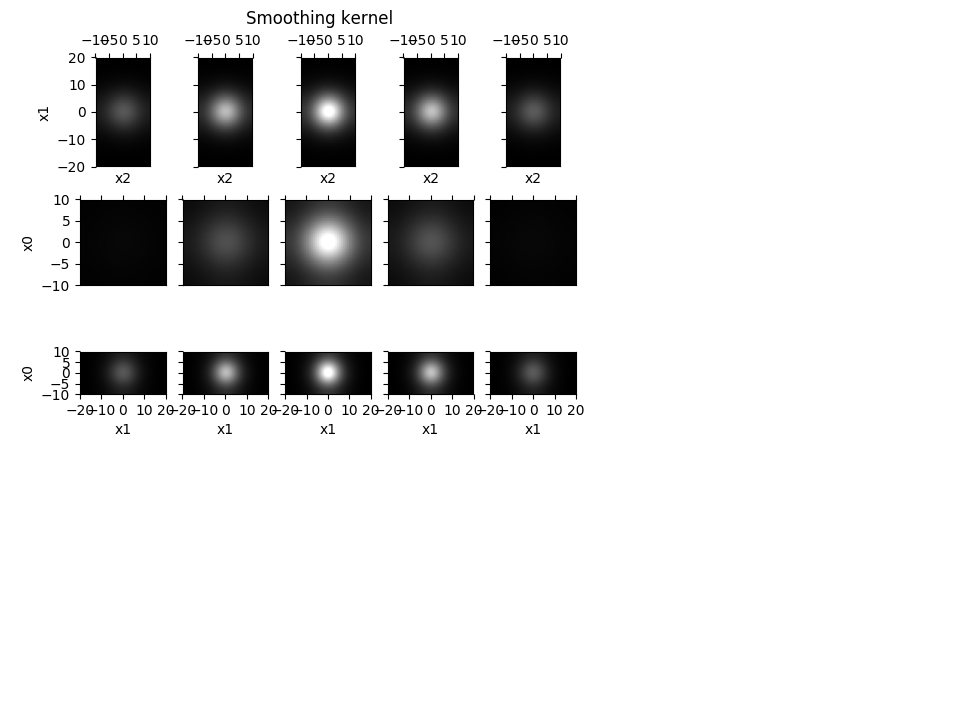

Built energy operators
Built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


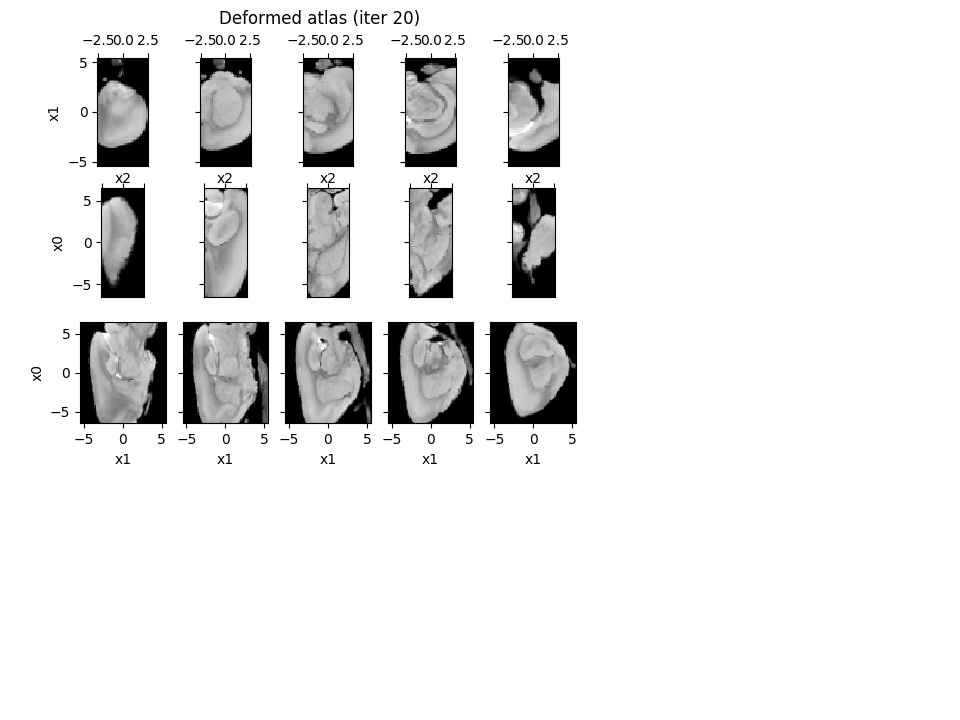

<IPython.core.display.Javascript object>


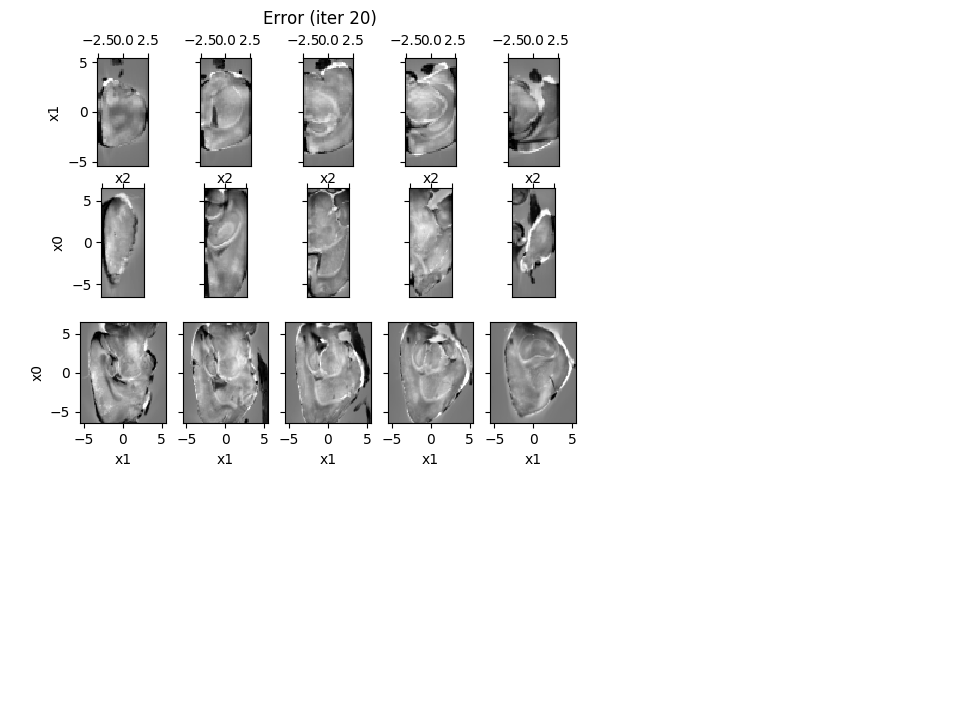

<IPython.core.display.Javascript object>


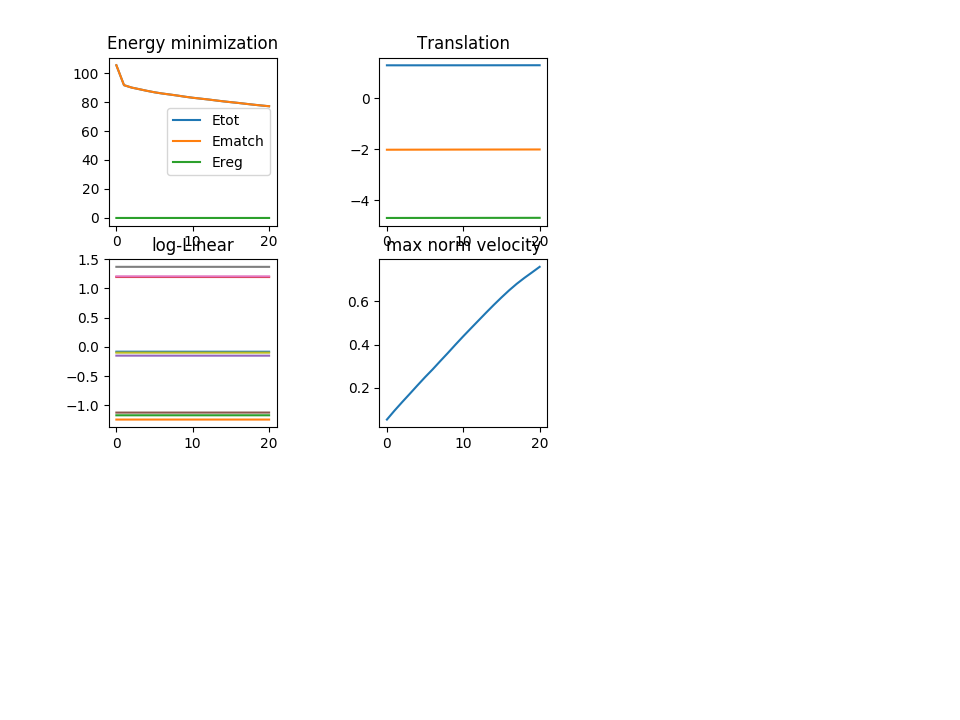

<IPython.core.display.Javascript object>


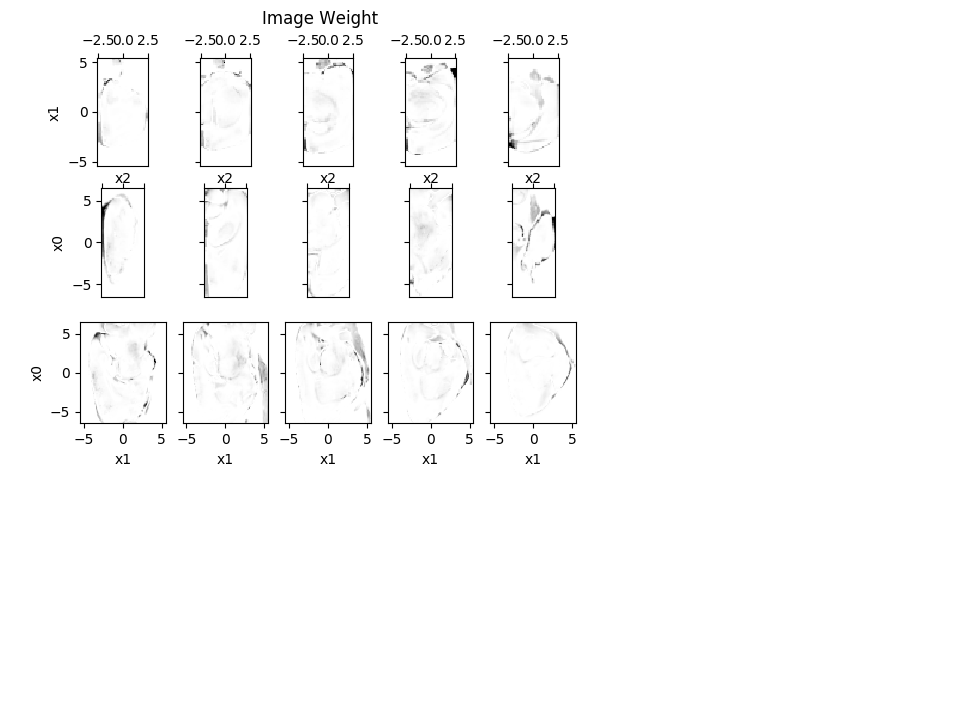

<IPython.core.display.Javascript object>


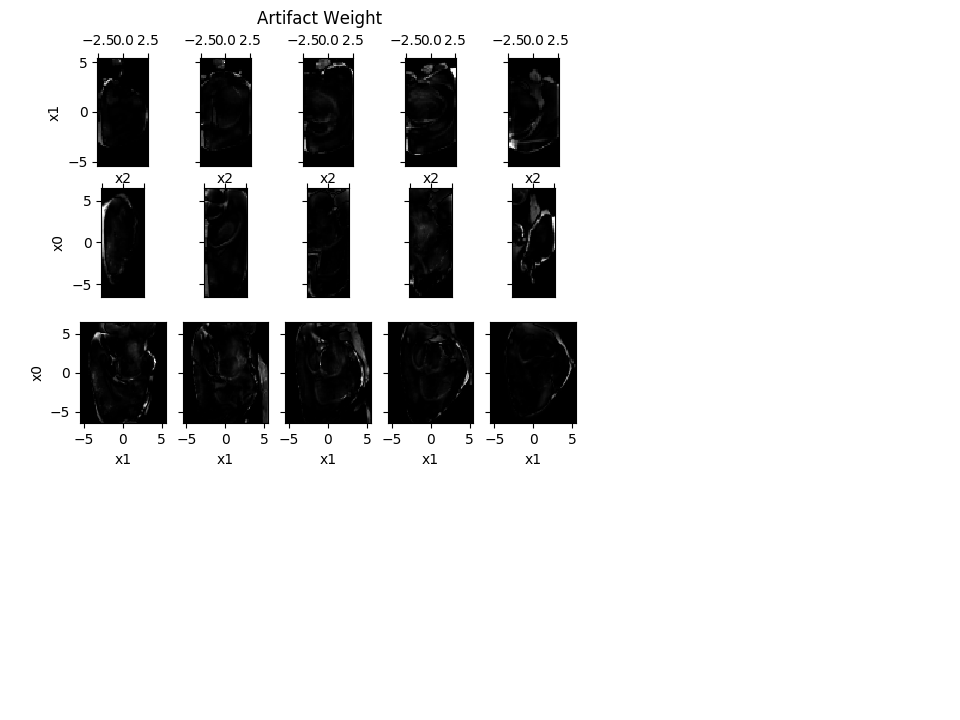

Taking affine and deformation step
Updating weights
logm result may be inaccurate, approximate err = 3.9691671554829685e-07
Finished iteration 0, energy 1.053928e+02 (match 1.053928e+02, reg 0.000000e+00)
Taking affine and deformation step
Updating weights
logm result may be inaccurate, approximate err = 4.914058968835553e-07
Finished iteration 1, energy 9.164024e+01 (match 9.164023e+01, reg 1.207191e-05)
Taking affine and deformation step
Updating weights
logm result may be inaccurate, approximate err = 5.493195716651024e-07
Finished iteration 2, energy 8.997646e+01 (match 8.997642e+01, reg 3.738004e-05)
Taking affine and deformation step
Updating weights
logm result may be inaccurate, approximate err = 4.190594811937531e-07
Finished iteration 3, energy 8.886652e+01 (match 8.886645e+01, reg 7.299191e-05)
Taking affine and deformation step
Updating weights
logm result may be inaccurate, approximate err = 1.9337764374581323e-07
Finished iteration 4, energy 8.773420e+01 (match 8.773409e+

In [ ]:
import imp
imp.reload(lddmm)
down = 2**ndown
niter = 50
naffine = 0


# deformation
nt = 5
a = 2.0
eV = 5e0
sigmaR = 1e10
# with eV 5e0, and sigmaR 1e10, we get to 1 after 30 iterations
# we oscilated with eV 1e1
sigmaR = 1e3


outd1 = lddmm.lddmm(Id,Jd,
                    xI=xId,xJ=xJd,
                    a = a,
                    A0=outd2['A'],
                    niter = niter,
                    naffine=naffine,
                    eT=eT*down, eL=eL*down, eV=eV*down,
                    nMstep=nMstep, nMstep_affine=nMstep_affine,
                    sigmaM=sigmaM,sigmaR=sigmaR
                   )

In [ ]:
# now go to native resolution
# first upsample the v
shape = np.array([I.shape[0],I.shape[1],I.shape[2],nt])
vt0 = np.zeros(shape)
vt1 = np.zeros(shape)
vt2 = np.zeros(shape)
for t in range(nt):
    vt0[:,:,:,t] = lddmm.upsample(out['vt0'],nup)
    vt1[:,:,:,t] = lddmm.upsample(out['vt1'],nup)
    vt2[:,:,:,t] = lddmm.upsample(out['vt2'],nup)

In [ ]:
# now do lddmm


# Deform the labels and see the quality

# Now if the quality is good, write out the labels at high resolution

# scratch